In [1]:
"""
쇼어의 알고리즘에서 지수 시간 복잡도를 가지는 부분
f(x) = a^x(modN) 함수의 주기 찾기

퀀텀 푸리에 변환 (QFT: Quantum Fourier Transform)
- 양자 컴퓨터로 푸리에 변환을 병렬적으로 수행 (비트 수와 무관)
- 역푸리에 변환(I-QFT: Inverse-QFT)으로 주기를 찾을 수 있음

쇼어 알고리즘을 수행하기 위한 양자 컴퓨터의 조건
- N의 비트수(b) + I-QFT를 실행하기 위한 비트 수(2b) = 3b의 큐비트 필요
- RSA-2048을 깨기 위해선 6144 큐비트 필요
- 큐비트 수를 줄이기 위한 연구도 있음.
"""
import math
import random
import numpy as np
from fractions import Fraction
from qiskit import Aer, QuantumCircuit, execute
import matplotlib.pyplot as plt

In [2]:
def factorize4(N):
    trial = 0
    while (True):
        trial += 1
        print('trial =', trial)
        a = random.randint(2, N - 1)
        if a not in [2, 7, 8, 11, 13]:
            continue
        r, qc = findPeriodByQuantumCircuit(N, a)
        print('\ta =', a, 'r =', r)
        if (r % 2 != 0):
            continue
        gcd1 = math.gcd(N, a ** (r // 2) + 1)
        gcd2 = math.gcd(N, a ** (r // 2) - 1)
        print('\tgcd1 =', gcd1, 'gcd2 =', gcd2)
        if (gcd1 == 1 or gcd2 == 1):
            continue
        return gcd1, gcd2, qc

In [3]:
"""
f(x) = a^x(modN)의 주기 찾기
- 양자 위상 추정: Quantum Phase Estimation
- 연분수 확장: Continued Fraction
"""

def findPeriodByQuantumCircuit(N,a):
    phase, qc = qpe_amod15(a)
    frac = Fraction(phase).limit_denominator(15) # 분모가 15인 연분수 확장
    return frac.denominator, qc

# 함수 f(x)의 양자 위상 추정(QPE)
def qpe_amod15(a):
    n_count = 3
    qc = QuantumCircuit(4 + n_count, n_count) # 양자 회로 7개에 고전 회로 3개
    
    for q in range(n_count):
        qc.h(q) # 양자 회로 3개에 Hadamard 게이트
    qc.x(3 + n_count) # 마지막 회로에 NOT 게이트
    
    for q in range(n_count):
        qc.append(c_amod15(a, 2**q), [q] + [i + n_count for i in range(4)])
    qc.append(qft_dagger(n_count), range(n_count))
    
    # 측정 및 시뮬레이터 실행
    
    qc.measure(range(n_count), range(n_count)) # 측정
    backend = Aer.get_backend('qasm_simulator')
    result = execute(qc, backend, shots=8192, memory=True).result()
    
    readings = result.get_memory()
    phase = int(readings[0], 2) / (2**n_count)
    
    return phase, qc

In [4]:
# 모듈러 거듭제곱 연산을 위한 양자 회로
def c_amod15(a, power):
    #if a not in [2, 7, 8, 11, 13]:
    #    raise ValueError("'a' must be in [2, 7, 8, 11, 13]")
    U = QuantumCircuit(4)
    for iteration in range(power):
        if a in [2, 13]:
            U.swap(0,1); U.swap(1,2); U.swap(2,3)
        if a in [7,8]:
            U.swap(2,3); U.swap(1,2); U.swap(0,1)
        if a == 11:
            U.swap(1,3); U.swap(0,2)
        if a in [7, 11, 13]:
            for q in range(4):
                U.x(q)
    U = U.to_gate()
    U.name = " %i^%i mod15" % (a, power)
    c_U = U.control()
    return c_U

In [5]:
# 양자 역 퓨리에 변환: Inverse QFT
def qft_dagger(n):
    qc = QuantumCircuit(n)
    for qubit in range(n//2):
        qc.swap(qubit, n - qubit - 1)
    for j in range(n):
        for m in range(j):
            qc.cp(-np.pi / float(2**(j-m)), m, j)
        qc.h(j)
    
    qc.name = " QFT† (I-QFT)"
    return qc

#You should use the QuantumCircuit.cp method instead, which acts identically.
# qc.cu1(-np.pi / float(2**(j-m)), m, j)

In [20]:
def main():
    N = 3*5
    p, q, qc = factorize4(N)
    print(N, '=', p, '*', q)
    qc.draw()

In [21]:
import time
start = time.time()
main()
end = time.time()
print('실행시간:', end-start)

trial = 1
trial = 2
trial = 3
	a = 11 r = 1
trial = 4
trial = 5
	a = 2 r = 1
trial = 6
	a = 8 r = 4
	gcd1 = 5 gcd2 = 3
15 = 5 * 3
실행시간: 0.8710262775421143


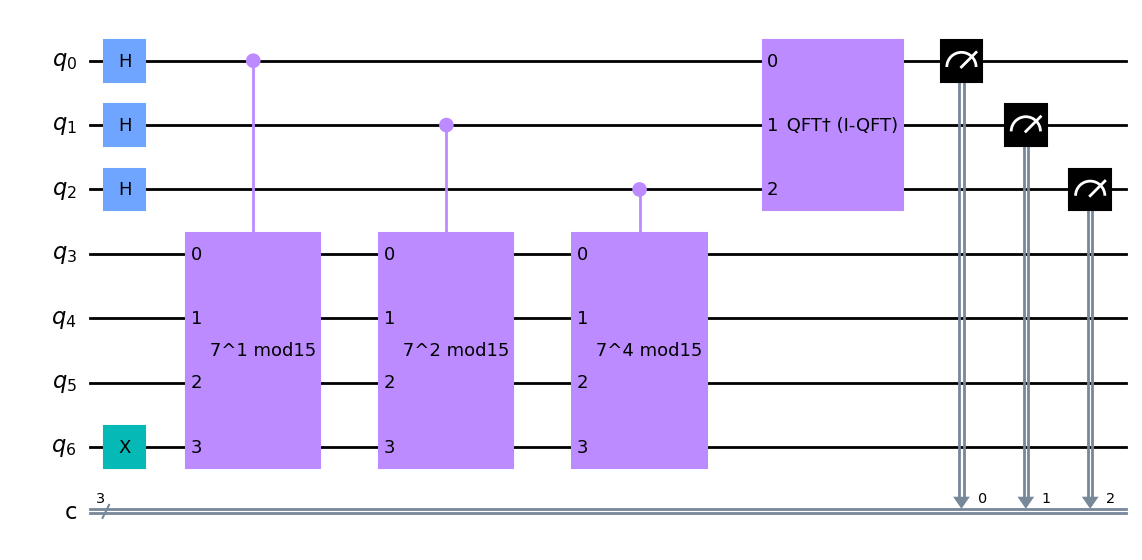

In [22]:
a = 7
phase, qc = qpe_amod15(a)
qc.draw('mpl')

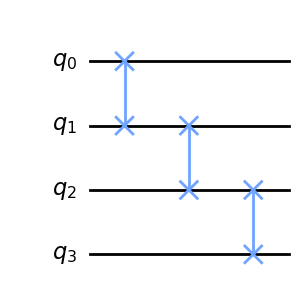

In [23]:
a = 2
power = 1

U = QuantumCircuit(4)
for iteration in range(power):
    if a in [2, 13]:
        U.swap(0,1); U.swap(1,2); U.swap(2,3)
    if a in [7,8]:
        U.swap(2,3); U.swap(1,2); U.swap(0,1)
    if a == 11:
        U.swap(1,3); U.swap(0,2)
    if a in [7, 11, 13]:
        for q in range(4):
            U.x(q)
            
U.draw('mpl')

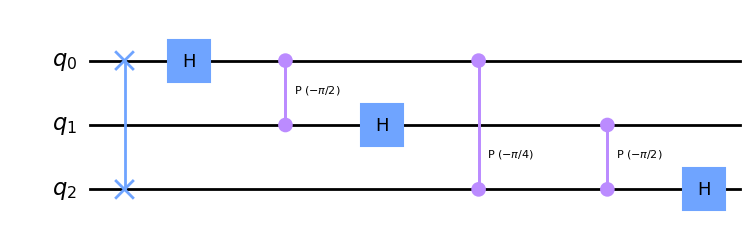

In [24]:
qc = qft_dagger(3)
qc.draw('mpl')

In [26]:
# 실제 양자 컴퓨터에서 실행해보기
from qiskit import IBMQ
IBMQ.save_account('1d7f90e74cc8bb9678523540eaf574c9c5f2f6f0a8c77a64d131cdac72a8ee2bbe2c1fc9c3dff13b4c055baaaef3813bcbbf15159b6c2b5fcf565ce2fa8033fe', overwrite = True)
IBMQ.load_account()
provider = IBMQ.get_provider('ibm-q')

def qpe_amod15(a):
    n_count = 3
    qc = QuantumCircuit(4 + n_count, n_count)
    
    for q in range(n_count):
        qc.h(q)
    qc.x(3 + n_count)
    
    for q in range(n_count):
        qc.append(c_amod15(a, 2**q), [q] + [i + n_count for i in range(4)])
    qc.append(qft_dagger(n_count), range(n_count))
    
    qc.measure(range(n_count), range(n_count))
    
    backend = provider.get_backend('ibm_lagos')
    result = execute(qc, backend, shots=8192, memory=True).result()
    
    readings = result.get_memory()
    phase = int(readings[0], 2) / (2**n_count)
    
    return phase, qc

start = time.time()
main()
end = time.time()
print("실행시간:", end-start)

ibmqfactory.load_account:WARNING:2023-10-20 09:51:57,889: Credentials are already in use. The existing account in the session will be replaced.


trial = 1
trial = 2
	a = 7 r = 8
	gcd1 = 1 gcd2 = 15
trial = 3
	a = 7 r = 8
	gcd1 = 1 gcd2 = 15
trial = 4
trial = 5
trial = 6
	a = 13 r = 1
trial = 7
trial = 8
trial = 9
trial = 10
trial = 11
	a = 11 r = 8
	gcd1 = 1 gcd2 = 15
trial = 12
trial = 13
	a = 7 r = 8
	gcd1 = 1 gcd2 = 15
trial = 14
trial = 15
	a = 13 r = 4
	gcd1 = 5 gcd2 = 3
15 = 5 * 3
실행시간: 265.7266228199005
